In [14]:
import kagglehub
import os
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models

dataset_path = kagglehub.dataset_download("rhammell/planesnet")
print("Downloaded dataset at:", dataset_path)

# extract labels
image_dir = os.path.join(dataset_path, "planesnet", "planesnet")
image_paths = sorted(glob.glob(os.path.join(image_dir, "*.png")))

Downloaded dataset at: /kaggle/input/planesnet


In [15]:
X = []
y = []
for img_path in image_paths:
    filename = os.path.basename(img_path)
    label = int(filename.split("_")[0])
    img = cv2.imread(img_path)
    img = cv2.resize(img, (20, 20))  # resize to the needed shape
    X.append(img)
    y.append(label)

X = np.array(X)
y = np.array(y)
# Normalize
X = X / 255.0

print("Loaded:", len(X), "images")
print("Shape:", X.shape, "Labels:", np.bincount(y))
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Loaded: 32000 images
Shape: (32000, 20, 20, 3) Labels: [24000  8000]


In [24]:
from tensorflow.keras import layers, models, regularizers

# CNN Model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(20, 20, 3)),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling2D(),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 20, 20, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 10, 10, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 10, 10, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 5, 5, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 5, 5, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 5, 5, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 102,465 (400.25 KB)

 Trainable params: 102,017 (398.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(patience=5, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=15,
    batch_size=64,
    validation_split=0.1,
    shuffle=True,
    verbose=1,
    callbacks=[early_stop]
)

Epoch 1/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - accuracy: 0.8788 - loss: 0.3448 - val_accuracy: 0.7430 - val_loss: 2.8115
Epoch 2/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9591 - loss: 0.1512 - val_accuracy: 0.9539 - val_loss: 0.1445
Epoch 3/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9665 - loss: 0.1156 - val_accuracy: 0.9664 - val_loss: 0.1072
Epoch 4/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9768 - loss: 0.0828 - val_accuracy: 0.9066 - val_loss: 0.2376
Epoch 5/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9788 - loss: 0.0735 - val_accuracy: 0.8570 - val_loss: 0.4342
Epoch 6/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9837 - loss: 0.0590 - val_accuracy: 0.8992 - val_loss: 0.2845
Epoch 7/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9828 - loss: 0.0611 - val_accuracy: 0.8301 - val_loss: 0.4732
Epoch 8/15
360/360 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9874 - loss: 0.0431 - val_accuracy: 0.

In [26]:
# Evaluate
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"\n Test accuracy: {test_acc:.2%}")

200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9663 - loss: 0.1084

 Test accuracy: 96.50%


In [34]:
import cv2
scene_path = os.path.join(dataset_path, "scenes", "scenes", "scene_1.png")
scene = cv2.imread(scene_path)
scene_rgb = cv2.cvtColor(scene, cv2.COLOR_BGR2RGB)

height, width, _ = scene.shape
win_size = 20
stride = 2  # sliding window size
detections = []

In [35]:
patches = []
coords = []

for y in range(0, height - win_size + 1, stride):
    for x in range(0, width - win_size + 1, stride):
        patch = scene[y:y+win_size, x:x+win_size]
        patch = patch.astype(np.float32) / 255.0
        patches.append(patch)
        coords.append((x, y))

patches_array = np.array(patches)  # Shape: (num_patches, 20, 20, 3)

# all at once
preds = model.predict(patches_array, verbose=1).flatten()

# Filter with probability
detections = [(coords[i][0], coords[i][1], preds[i]) for i in range(len(preds)) if preds[i] > 0.9]

print(f" Detected {len(detections)} potential planes.")

10553/10553 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step
 Detected 274 potential planes.


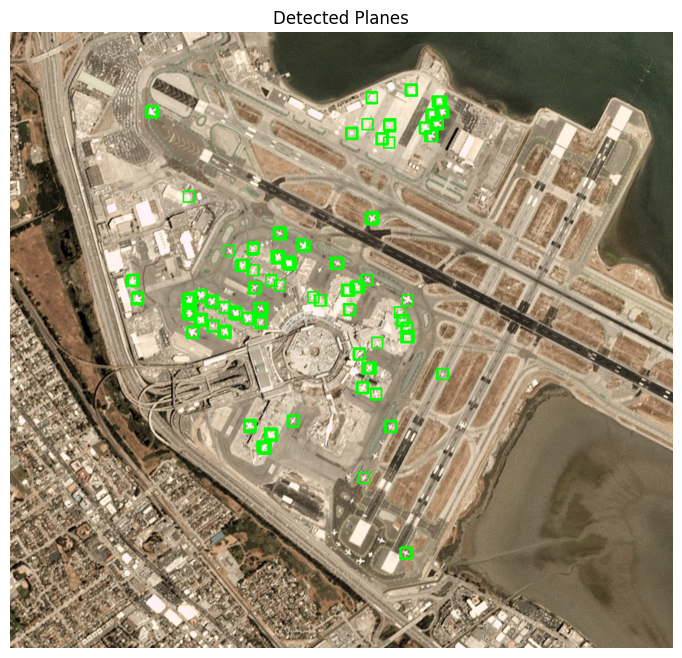

In [36]:
# the detection boxes
for (x, y, p) in detections:
    cv2.rectangle(scene_rgb, (x, y), (x+win_size, y+win_size), (0, 255, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(scene_rgb)
plt.title("Detected Planes")
plt.axis("off")
plt.show()